In [11]:
import matplotlib
# %matplotlib inline
matplotlib.use('nbagg')
import matplotlib.pyplot as plt
from pylab import rcParams
# rcParams['figure.figsize'] = 10, 5
rcParams['figure.max_open_warning'] = False
%load_ext autoreload
%autoreload 2
import logging
logging.basicConfig(level=logging.INFO)
import numpy as np
import scipy

In [4]:
'''Trains a simple convnet on the MNIST dataset.
Gets to 99.25% test accuracy after 12 epochs
(there is still a lot of margin for parameter tuning).
16 seconds per epoch on a GRID K520 GPU.
'''

from __future__ import print_function
import keras
from keras.datasets import mnist
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras import backend as K

batch_size = 128
num_classes = 10
epochs = 4

# input image dimensions
img_rows, img_cols = 28, 28

# the data, shuffled and split between train and test sets
(x_train, y_train), (x_test, y_test) = mnist.load_data()

x_train = x_train.reshape(x_train.shape[0], img_rows, img_cols, 1)
x_test = x_test.reshape(x_test.shape[0], img_rows, img_cols, 1)
input_shape = (img_rows, img_cols, 1)

x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train /= 255
x_test /= 255
print('x_train shape:', x_train.shape)
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')

# convert class vectors to binary class matrices
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

model = Sequential()
model.add(Conv2D(32, kernel_size=(3, 3),
                 activation='relu',
                 input_shape=input_shape,
                 use_bias=False))
model.add(Conv2D(64, (3, 3), activation='relu', use_bias=False))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(num_classes, activation='softmax'))

model.compile(loss=keras.losses.categorical_crossentropy,
              optimizer=keras.optimizers.Adadelta(),
              metrics=['accuracy'])

model.fit(x_train, y_train,
          batch_size=batch_size,
          epochs=epochs,
          verbose=1,
          validation_data=(x_test, y_test))
score = model.evaluate(x_test, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

x_train shape: (60000, 28, 28, 1)
60000 train samples
10000 test samples
Train on 60000 samples, validate on 10000 samples
Epoch 1/4
60000/60000 [==============================] - 105s - loss: 0.3302 - acc: 0.9005 - val_loss: 0.0767 - val_acc: 0.9749
Epoch 2/4
60000/60000 [==============================] - 95s - loss: 0.1116 - acc: 0.9673 - val_loss: 0.0526 - val_acc: 0.9833
Epoch 3/4
60000/60000 [==============================] - 95s - loss: 0.0834 - acc: 0.9746 - val_loss: 0.0408 - val_acc: 0.9866
Epoch 4/4
60000/60000 [==============================] - 95s - loss: 0.0718 - acc: 0.9789 - val_loss: 0.0381 - val_acc: 0.9884
Test loss: 0.0380918546026
Test accuracy: 0.9884


In [5]:
model.save('mnist_nobias.h5')

In [19]:
from keras.models import load_model
from keras.utils import np_utils

model = load_model('mnist.h5')
model_nobias = load_model('mnist_nobias.h5')

In [18]:
def vis(model, i):
    c = model.layers[i].get_weights()[0]
    print(c.shape)
    cs = c.reshape(list(reversed(c.shape)))
    print(cs.max(), cs.min())
    print(cs.size)

    s = []
    m = []
    a = []
    for x in cs:
        for xx in x:
            s.append(np.sum(np.abs(xx)))
            if x.max() > np.abs(x.min()):
                m.append(x.max())
            else:
                m.append(x.min())
            a.append(np.mean(x))
    #         print(np.sum(xx))

    plt.plot(s)
    plt.plot(m)
    plt.plot(a)
    plt.show()

(3, 3, 1, 32)
0.381016 -0.324338
288


<IPython.core.display.Javascript object>


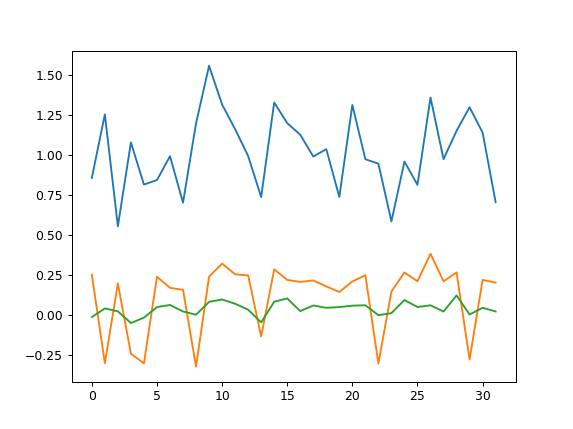

(3, 3, 32, 64)
0.225378 -0.215311
18432


<IPython.core.display.Javascript object>


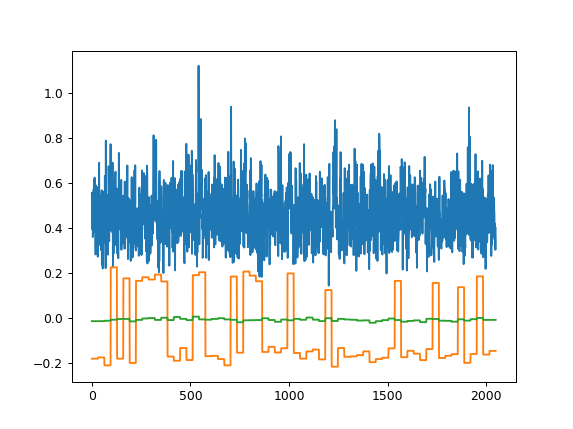

In [20]:
vis(model, 0)
vis(model, 1)

(3, 3, 1, 32)
0.274144 -0.244598
288


<IPython.core.display.Javascript object>


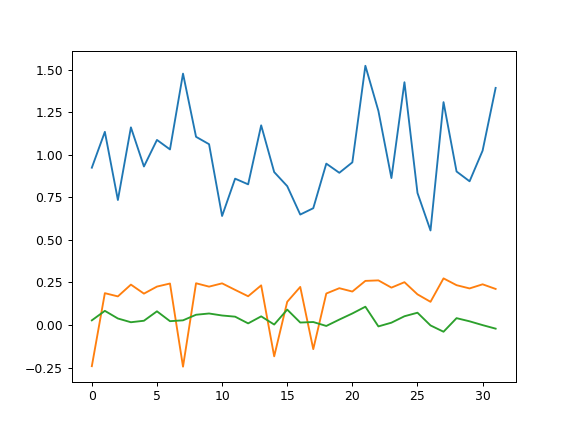

(3, 3, 32, 64)
0.238972 -0.203996
18432


<IPython.core.display.Javascript object>


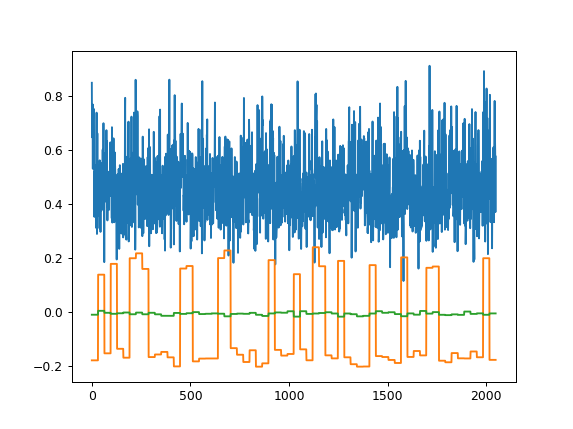

In [21]:
vis(model_nobias, 0)
vis(model_nobias, 1)

In [27]:
model_nobias.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_5 (Conv2D)            (None, 26, 26, 32)        288       
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 24, 24, 64)        18432     
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 12, 12, 64)        0         
_________________________________________________________________
dropout_5 (Dropout)          (None, 12, 12, 64)        0         
_________________________________________________________________
flatten_3 (Flatten)          (None, 9216)              0         
_________________________________________________________________
dense_5 (Dense)              (None, 128)               1179776   
_________________________________________________________________
dropout_6 (Dropout)          (None, 128)               0         
__________

# Replicate first layer

<IPython.core.display.Javascript object>


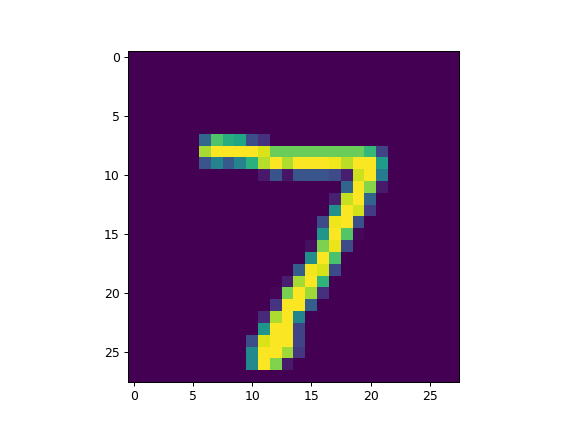

In [146]:
im = x_test[0].reshape((28, 28))
plt.imshow(im)
plt.show()

[[-0.24170612 -0.18796363 -0.24459821]
 [ 0.01745991 -0.00979571  0.00914394]
 [ 0.25938731  0.25174075  0.12395487]]


<IPython.core.display.Javascript object>


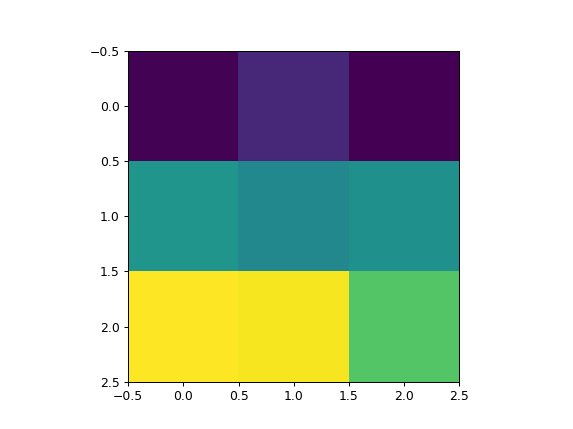

In [190]:
orig_w = model_nobias.layers[0].get_weights()
# cs = orig_w[0].reshape(list(reversed(orig_w[0].shape)))

f = orig_w[0][:,:,:,0].reshape(3,3)
# f = cs[0].reshape(3,3)
print(f)
plt.imshow(f)
plt.show()

In [191]:
from scipy import signal
grad = signal.convolve2d(im, f)
# print(grad)

(30, 30)
0.641956 -0.667615


<IPython.core.display.Javascript object>


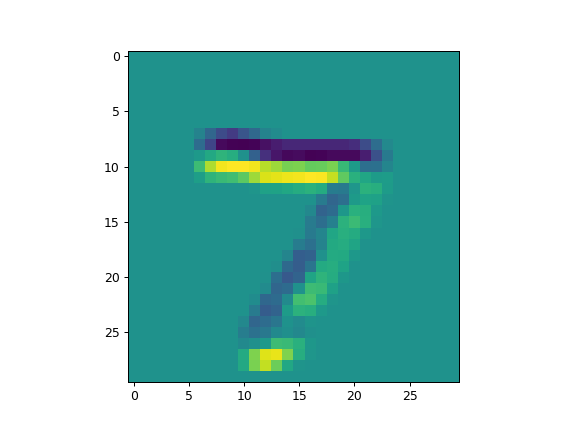

In [192]:
print(grad.shape)
print(grad.max(), grad.min())
plt.imshow(grad)
plt.show()

In [197]:
mw = model1.layers[0].get_weights()[0]
print(w[:,:,:,0].reshape(3,3))

[[-0.24170612 -0.18796363 -0.24459821]
 [ 0.01745991 -0.00979571  0.00914394]
 [ 0.25938731  0.25174075  0.12395487]]


In [202]:
model1 = Sequential()
model1.add(Conv2D(32, kernel_size=(3, 3),
#                  activation='relu',
                 input_shape=input_shape,
                 use_bias=False))
model1.layers[0].set_weights(orig_w)


w = model1.layers[0].get_weights()[0]
print(w[:,:,:,0])

data = x_test
o = model1.predict(data, verbose=1)[0]

[[[-0.24170612]
  [-0.18796363]
  [-0.24459821]]

 [[ 0.01745991]
  [-0.00979571]
  [ 0.00914394]]

 [[ 0.25938731]
  [ 0.25174075]
  [ 0.12395487]]]
 9760/10000 [============================>.] - ETA: 0s

<IPython.core.display.Javascript object>


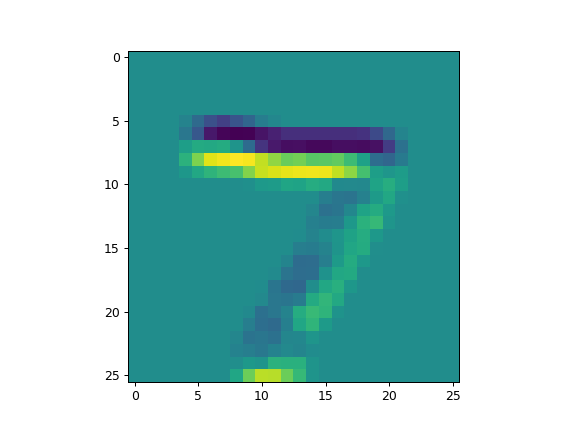

In [205]:
# o[:,:,0].shape
plt.imshow(o[:,:,31])
plt.show()

In [87]:
def to_normal_shape(x):
    return np.array(x).reshape(list(reversed(np.array(x).shape)))

In [129]:
from keras.models import Model
data = x_train[0:1]
intermediate_layer_model = Model(inputs=model.input,
                                 outputs=model.layers[0].output)
intermediate_output = intermediate_layer_model.predict(data)
print(intermediate_output.shape)

(1, 26, 26, 32)


[[[[ 0.]]

  [[ 0.]]

  [[ 0.]]

  [[ 0.]]

  [[ 0.]]

  [[ 0.]]

  [[ 0.]]

  [[ 0.]]

  [[ 0.]]

  [[ 0.]]

  [[ 0.]]

  [[ 0.]]

  [[ 0.]]

  [[ 0.]]

  [[ 0.]]

  [[ 0.]]

  [[ 0.]]

  [[ 0.]]

  [[ 0.]]

  [[ 0.]]

  [[ 0.]]

  [[ 0.]]

  [[ 0.]]

  [[ 0.]]

  [[ 0.]]

  [[ 0.]]]


 [[[ 0.]]

  [[ 0.]]

  [[ 0.]]

  [[ 0.]]

  [[ 0.]]

  [[ 0.]]

  [[ 0.]]

  [[ 0.]]

  [[ 0.]]

  [[ 0.]]

  [[ 0.]]

  [[ 0.]]

  [[ 0.]]

  [[ 0.]]

  [[ 0.]]

  [[ 0.]]

  [[ 0.]]

  [[ 0.]]

  [[ 0.]]

  [[ 0.]]

  [[ 0.]]

  [[ 0.]]

  [[ 0.]]

  [[ 0.]]

  [[ 0.]]

  [[ 0.]]]


 [[[ 0.]]

  [[ 0.]]

  [[ 0.]]

  [[ 0.]]

  [[ 0.]]

  [[ 0.]]

  [[ 0.]]

  [[ 0.]]

  [[ 0.]]

  [[ 0.]]

  [[ 0.]]

  [[ 0.]]

  [[ 0.]]

  [[ 0.]]

  [[ 0.]]

  [[ 0.]]

  [[ 0.]]

  [[ 0.]]

  [[ 0.]]

  [[ 0.]]

  [[ 0.]]

  [[ 0.]]

  [[ 0.]]

  [[ 0.]]

  [[ 0.]]

  [[ 0.]]]


 [[[ 0.]]

  [[ 0.]]

  [[ 0.]]

  [[ 0.]]

  [[ 0.]]

  [[ 0.]]

  [[ 0.]]

  [[ 0.]]

  [[ 0.]]

  [[ 0.]]

  [[ 0.]]

  [[ 0.]]

  [[

<IPython.core.display.Javascript object>


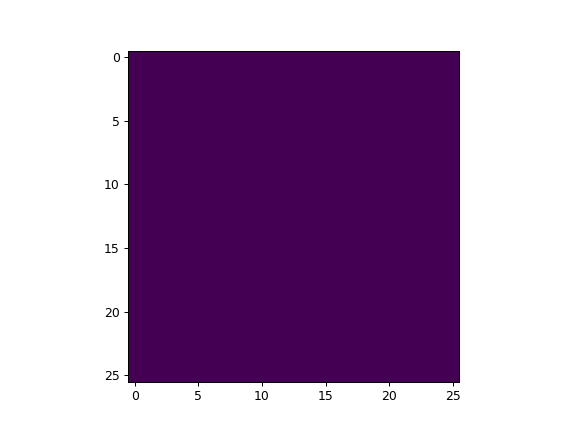

In [124]:
model = model_nobias

get_3rd_layer_output = K.function([model.input, K.learning_phase()],
                                  [model.layers[0].output])

# output in test mode = 0
x = x_train[0:1]
layer_output = get_3rd_layer_output([x, 0])
outs = to_normal_shape(layer_output)
print(outs[0])
# print(to_normal_shape(layer_output)[0])
plt.imshow(outs[0].reshape(26,26))
plt.show()

# output in train mode = 1
# layer_output = get_3rd_layer_output([x, 1])[0]

In [84]:
from keras import backend as K

inp = model.input                                           # input placeholder
outputs = [layer.output for layer in model.layers]          # all layer outputs
functors = [K.function([inp]+ [K.learning_phase()], [out]) for out in outputs]  # evaluation functions

# Testing
# test = np.random.random(input_shape)[np.newaxis,...]
test = x_train[0].reshape(1, 28,28,1)
layer_outs = [func([test, 1.]) for func in functors]
print(np.array(layer_outs[0]).shape)

(1, 1, 26, 26, 32)


(26, 26)


<IPython.core.display.Javascript object>


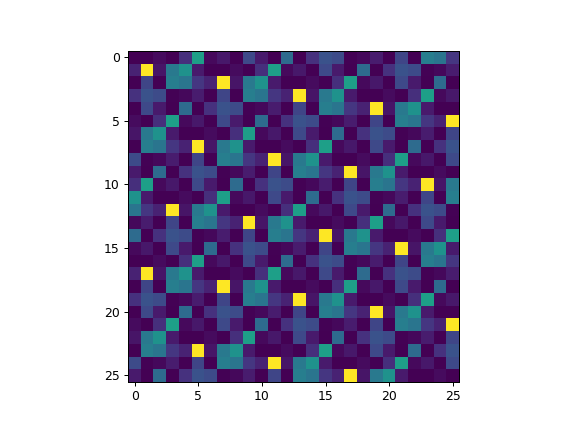

In [104]:
outs = to_normal_shape(layer_outs[0])
# print(outs[0])
print(outs[0].reshape(26, 26).shape)
plt.imshow(outs[2].reshape(26,26))
plt.show()

(32, 26, 26, 1)


<IPython.core.display.Javascript object>


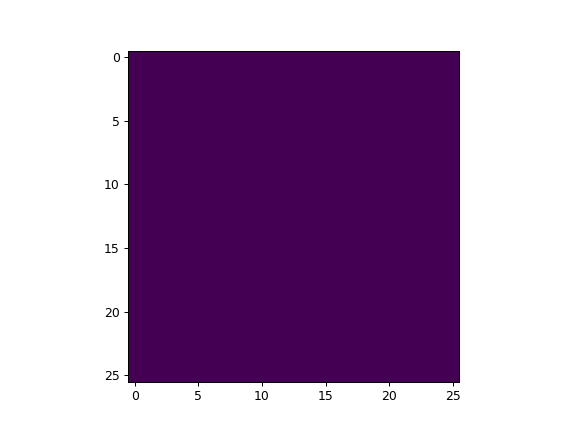

In [98]:
o = model1.predict(x_train[0].reshape(1, 28,28,1))
o = o.reshape(list(reversed(o.shape)))
print(o.shape)
plt.imshow(o[0].reshape(26,26))
plt.show()